In [1]:
import json
import pandas as pd
import numpy as np
import os
import datetime as ddt
from scipy import stats
from tqdm import tqdm
import numba as nb




from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))  # 全屏展示
pd.set_option('display.max_columns', None)

### 1、征信报告加工滑动窗口的特征

In [2]:


def to_float_ornan(value):
    """数值转换"""
    if not str(value).strip():return np.nan
    try:
        value = float(value)
        if value % 1 == 0:
            return int(value)
        return value
    except:
        return  np.nan
    

def add_notna_set(seta, value):
    """非空计数"""
    if str(value).strip():
        seta.append(value)
        
    
def diff_date(dt1, dt2):
    """日期间隔"""
    try:
        a = ddt.datetime.strptime(str(dt1),"%Y%m%d") 
        if len(dt2) >4:
            b =  ddt.datetime.strptime(str(dt2),"%Y%m%d")
        else:
            b =  ddt.datetime.strptime(str(dt2),"%Y")
    except:
        return np.nan
    return (a-b).days

def get_muti_max(datas, key):
    """取多条记录求和或者最大值"""
    temp_list = []
    
    for data in con_list(datas):
        if key == 'Duecount' or key == 'Duesum':
            temp_list.append(to_float_ornan(data['Days_Past_Due']))
        else :
            temp_list.append(to_float_ornan(data[key]))
    if key == 'Duecount':
        return len(temp_list)
    elif key == 'Duesum':
        return np.nansum(temp_list)
    
    return np.nanmax(temp_list)
    
def con_list(mult_datas): 
    if type(mult_datas) != list:
        return [mult_datas] # 统一为列表形式
    else:
        return mult_datas
    
def calclen(alist):
    """一致率计算，最小为1.越大表示信息越一致 """
    return (len(alist)+0.001)/(len(set(alist))+0.001)
    
# 自定义函数库
fun_dict = {
    'count':len,
    'sum':np.nansum,
    'mean':np.nanmean,
    'median':np.nanmedian,
    'max':np.nanmax,
    'min':np.nanmin,
    'std':np.nanstd,
    'nuniq':lambda x: len(set(x)),
    'mode':lambda x:stats.mode(x, nan_policy='omit')[0][0],
    'maxcount':lambda x:stats.mode(x, nan_policy='omit')[1][0]
}



def add_fea_grids(fea_dict, mult_datas, apply_dt='20200101', dt_key='Open_Date', calc_key="data['Amount_Past_Due']",groupfun=['count','sum', 'median','mean','max','min','std'], dt_grids=[7, 30,60,360,9999]):
    """
    征信报告使用滑动时间窗口-近N天，加工字段A的 计数、平均、求和等特征.
    fea_dict:最终特征存储的字典
    mult_datas:多条的记录值
    calc_key:数据特征字段的相对位置 
    """
    new_fea = {} # 记录各时间窗口的原始特征
    for _dt in dt_grids:
        new_fea.setdefault(_dt, [])# 按时间窗口初始化
    fea_suffix = calc_key.split("'")[-2]  + str(len(calc_key))   # 前缀备注
    if mult_datas:
        mult_datas = con_list(mult_datas) 
        for data in mult_datas:
            if len(data[dt_key]) >=4  and  data[dt_key] < apply_dt: #筛选申请日期前的记录,报告应该为准实时调用的
                for _dt in dt_grids:
                    if (_dt==9999) or (ddt.datetime.strptime(str(data[dt_key]),"%Y%m%d") >= (ddt.datetime.strptime(str(apply_dt),"%Y%m%d") + ddt.timedelta(days=-_dt))) :# 筛选为近N天的记录，为9999则不做筛选
                        if "Date" in  calc_key or "Year" in   calc_key : #判断是否为日期型，日期直接计算为时间间隔
                            fea_value = diff_date(apply_dt, eval(calc_key) )
                        elif "mean" in groupfun: # 判断是否为数值型，直接提取到相应的时间窗
                            fea_value = to_float_ornan(eval(calc_key))
                        else:# 其他按字符型处理
                            fea_value = eval(calc_key)
                        new_fea[_dt].append(fea_value)  #  { 30: [2767.0, 0.0]}
    for _k, data_list in new_fea.items(): # 生成具体特征
        for fun in groupfun:
            fea_name = fea_suffix+ '_'+ fun + '_' +str(_k)
            fea_dict.setdefault(fea_name, [])
            if len(data_list) > 0:
                final_value = fun_dict[fun](data_list)
            else :
                final_value = np.nan
            fea_dict[fea_name].append(final_value)
        


In [4]:
# 特征字典初始化
fea_dict = {}
for _fea in (['ID','apply_dt','apply_amt', 'report_timestamp','BureauScore', 'BureauScoreConfidLevel', 'MissingRate', 'Current_Enquiry_Reason', 'Current_Finance_Purpose', 'Current_Amount_Financed', 
              'Current_Duration_Of_Agreement', 'Current_Gender_Code', 'First_Name1', 'Len_Name', 'Name_nuniq', 'Tel_nuniq', 'Email_nuniq', 'Tel_type', 
              'IncomeTaxPAN_4', 'IncomeTaxPAN_5', 'Diff_datePassport', 'Diff_datePAN', 'Diff_dateDriver', 'IsPassport', 'IsDriver', 'Current_Income', 
              'IncomeApplyPor', 'Marital_Status', 'Employment_Status', 'Time_with_Employer', 'Number_of_Major_Credit_Card_Held', 'Len_of_addrs', 
              'City_nuniq', 'Country_Code', 'PinCode3', 'Current_State', 'Current_City', 'CreditAccountActive', 'CreditAccountClosed', 
              'CreditAccountDefault', 'CreditAccountTotal', 'CADSuitFiledCurrentBalance', 'CreditAccountActivePor', 'CADSuitFiledCurrentBalancePer', 
              'Outstanding_Balance_Secured', 'Outstanding_Balance_UnSecured_Percentage', 'Outstanding_Balance_All', 'Outstanding_Balance_Secured_Percentage', 
              'Outstanding_Balance_UnSecured','Outstanding_Balance_All_CADSuitPor','Diff_dateBirth','State_nuniq','Birth_nuniq','TotalCAPSLast90Days',
              'TotalCAPSLast7Days','TotalCAPSLast30Days','TotalCAPSLast180Days','CAPSLast30Days', 'CAPSLast7Days', 'CAPSLast180Days', 'CAPSLast90Days',
              'NonCreditCAPSLast30Days', 'NonCreditCAPSLast180Days', 'NonCreditCAPSLast90Days', 'NonCreditCAPSLast7Days','Pin_nuniq','Pan_nuniq','Account_nuniq','Ident_nuniq',
              'Name_nuniq2','Tel_nuniq2','Email_nuniq2','Pan_nuniq2','Account_nuniq2','Ident_nuniq2','Gender_nuniq']):
    fea_dict.setdefault(_fea,[])




# 遍历征信报告文件，加工特征#
#考虑征信报告涉及数据隐私，本例仅提供一个样本的征信报告示例
file_dir = './'
files = os.listdir(file_dir)
files = [_f for _f in sorted(files ) if 'txt' in _f ]  # 读取当前征信报告.txt文件
respone_reasons = [] # 记录异常报文原因
for file in  tqdm(files):
    try:
        with open(file_dir + '/%s'%file, 'r') as file_obj:
            raw_fea = json.load(file_obj)["INProfileResponse"]  # ijson
            if raw_fea.get('UserMessage',{}).get('UserMessageText','') != 'Normal Response' :  # 非正常报文
                respone_reasons.append(raw_fea.get('UserMessage',{}).get('UserMessageText',''))
                continue
            apply_dt= raw_fea["CreditProfileHeader"].get('ReportDate','20220101')        #申请贷款日期=报告时间、额度无，默认以报告日期或固定值
            apply_amt = float(100000)    ## 
            
            # 非重复计数 初始化
            State_nuniq=[]
            Birth_nuniq=[]
            City_nuniq=[]
            Email_nuniq=[]
            Tel_nuniq=[]
            Name_nuniq=[]
            Pin_nuniq=[]
            Pan_nuniq=[]
            Account_nuniq=[]
            Ident_nuniq=[]
            Gender_nuniq=[]
            fea_dict['report_timestamp'].append(raw_fea["CreditProfileHeader"].get('ReportDate','') +  raw_fea["CreditProfileHeader"].get('ReportTime',''))
            fea_dict['ID'].append(file.split('.')[0]) # pan卡ID
            fea_dict['apply_dt'].append(apply_dt) 
            fea_dict['apply_amt'].append(apply_amt)
            
            
#             score类特征           
#             if len(raw_fea['SCORE']) != 1: print(file, 'SCORE') # 字段结构检验
            fea_dict['BureauScore'].append(to_float_ornan(raw_fea['SCORE'].get( 'BureauScore', np.nan))) 
            fea_dict['BureauScoreConfidLevel'].append(raw_fea['SCORE'].get( 'BureauScoreConfidLevel', ''))
            miss_rate = str(raw_fea).count("''")/ str(raw_fea).count(":") # 报告缺失率
            fea_dict['MissingRate'].append(miss_rate)
            

            # Current_Application类特征 
#             if len(raw_fea['Current_Application'])*\
#             len(raw_fea['Current_Application']['Current_Application_Details'])*\
#             len(raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Details'])*\
#             len(raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Address_Details'])*\
#             len(raw_fea['Current_Application']['Current_Application_Details']['Current_Other_Details']) != 1:
#                 print(file,'Current_Application') # 字段结构检验
            fea_dict['IncomeTaxPAN_4'].append(file[3])
            fea_dict['IncomeTaxPAN_5'].append(file[4])
            all_nm = '' # 名字信息-拼接
            for nm in ['First_Name',"Middle_Name1","Middle_Name2","Middle_Name3",'Last_Name']:
                if raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Details'].get(nm , '').strip():
                    all_nm += raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Details'].get(nm , '').strip() + ' '
            fea_dict['Len_Name'].append(len(all_nm)) # 名字长度
            fea_dict['First_Name1'].append(all_nm[0])
            add_notna_set(Name_nuniq, all_nm.lower().strip())
            add_notna_set(Tel_nuniq, raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Details'].get( 'Telephone_Number_Applicant_1st' , ''))
            add_notna_set(Tel_nuniq, raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Details'].get('MobilePhoneNumber',''))
            add_notna_set(Email_nuniq, raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Details'].get('EMailId','').lower().strip())
            fea_dict['Current_Enquiry_Reason'].append(raw_fea['Current_Application']['Current_Application_Details'].get('Enquiry_Reason','')) # 同类型特征待优化为for遍历
            fea_dict['Current_Finance_Purpose'].append(raw_fea['Current_Application']['Current_Application_Details'].get('Finance_Purpose',''))
            fea_dict['Current_Amount_Financed'].append(to_float_ornan(raw_fea['Current_Application']['Current_Application_Details'].get('Amount_Financed','')))
            fea_dict['Current_Duration_Of_Agreement'].append(to_float_ornan(raw_fea['Current_Application']['Current_Application_Details'].get('Duration_Of_Agreement' , '')))
            fea_dict['Current_Gender_Code'].append(raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Details'].get('Gender_Code' , ''))
            add_notna_set(Gender_nuniq, raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Details'].get('Gender_Code' , ''))
            fea_dict['Tel_type'].append(raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Details'].get('Telephone_Type', ''))
            fea_dict['IsPassport'].append(int(bool(raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Details'].get('Passport_Number' , ''))))
            fea_dict['IsDriver'].append(int(bool(raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Details'].get('Driver_License_Number' , ''))))
            add_notna_set(Birth_nuniq, raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Details'].get('Date_Of_Birth_Applicant' , ''))
            fea_dict['Diff_dateBirth'].append( diff_date(apply_dt,raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Details'].get('Date_Of_Birth_Applicant' , '')))
            fea_dict['Diff_datePAN'].append( diff_date(apply_dt,raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Details'].get('PAN_Issue_Date' , '')))
            fea_dict['Diff_datePassport'].append( diff_date(apply_dt,raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Details'].get('Passport_Issue_Date' , '')))
            fea_dict['Diff_dateDriver'].append( diff_date(apply_dt,raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Details'].get('Driver_License_Issue_Date' , '')))
            fea_dict['Current_Income'].append(to_float_ornan(raw_fea['Current_Application']['Current_Application_Details']['Current_Other_Details'].get('Income' , '')))
            fea_dict['IncomeApplyPor'].append(to_float_ornan(raw_fea['Current_Application']['Current_Application_Details']['Current_Other_Details'].get('Income' , ''))/apply_amt)
            fea_dict['Time_with_Employer'].append(to_float_ornan(raw_fea['Current_Application']['Current_Application_Details']['Current_Other_Details'].get('Time_with_Employer' , '')))
            fea_dict['Number_of_Major_Credit_Card_Held'].append(to_float_ornan(raw_fea['Current_Application']['Current_Application_Details']['Current_Other_Details'].get('Number_of_Major_Credit_Card_Held' , '')))
            fea_dict['Marital_Status'].append(raw_fea['Current_Application']['Current_Application_Details']['Current_Other_Details'].get('Marital_Status',''))
            fea_dict['Employment_Status'].append(raw_fea['Current_Application']['Current_Application_Details']['Current_Other_Details'].get('Employment_Status',''))
            all_addr = ''  # Current_Application地址信息特征
            for _addr in ['Country_Code', 'State', 'City', 'BldgNoSocietyName', 'RoadNoNameAreaLocality', 'FlatNoPlotNoHouseNo', 'Landmark']:
                all_addr += raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Address_Details'].get(_addr , '')
            fea_dict['Len_of_addrs'].append(len(all_addr))
            add_notna_set(City_nuniq, raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Address_Details'].get('City',''))
            add_notna_set(State_nuniq, raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Address_Details'].get('State',''))
            add_notna_set(Pin_nuniq, raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Address_Details'].get('PINCode',''))
            fea_dict['Country_Code'].append(raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Address_Details'].get('Country_Code',''))
            fea_dict['PinCode3'].append(raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Address_Details'].get('PINCode','')[:3])
            fea_dict['Current_State'].append(raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Address_Details'].get('State',''))
            fea_dict['Current_City'].append(raw_fea['Current_Application']['Current_Application_Details']['Current_Applicant_Address_Details'].get('City',''))

            #  CAIS_Account 类特征
#             if len(raw_fea['CAIS_Account'])*\
#             len(raw_fea['CAIS_Account']['CAIS_Summary'])*\
#             len(raw_fea['CAIS_Account']['CAIS_Summary']['Credit_Account'])*\
#             len(raw_fea['CAIS_Account']['CAIS_Summary']['Total_Outstanding_Balance']) != 1:
#                 print(file,'CAIS_Account') # 字段结构检验
            fea_dict['CreditAccountActive'].append(to_float_ornan(raw_fea['CAIS_Account']['CAIS_Summary']['Credit_Account'].get('CreditAccountActive','')))
            fea_dict['CreditAccountClosed'].append(to_float_ornan(raw_fea['CAIS_Account']['CAIS_Summary']['Credit_Account'].get('CreditAccountClosed','')))
            fea_dict['CreditAccountDefault'].append(to_float_ornan(raw_fea['CAIS_Account']['CAIS_Summary']['Credit_Account'].get('CreditAccountDefault','')))
            fea_dict['CreditAccountTotal'].append(to_float_ornan(raw_fea['CAIS_Account']['CAIS_Summary']['Credit_Account'].get('CreditAccountTotal','')))
            fea_dict['CADSuitFiledCurrentBalance'].append(to_float_ornan(raw_fea['CAIS_Account']['CAIS_Summary']['Credit_Account'].get('CADSuitFiledCurrentBalance','')))
            fea_dict['CreditAccountActivePor'].append(to_float_ornan(raw_fea['CAIS_Account']['CAIS_Summary']['Credit_Account'].get('CreditAccountActive',''))/(to_float_ornan(raw_fea['CAIS_Account']['CAIS_Summary']['Credit_Account'].get('CreditAccountTotal',''))+0.001))
            fea_dict['CADSuitFiledCurrentBalancePer'].append(to_float_ornan(raw_fea['CAIS_Account']['CAIS_Summary']['Credit_Account'].get('CADSuitFiledCurrentBalance',''))/(to_float_ornan(raw_fea['CAIS_Account']['CAIS_Summary']['Credit_Account'].get('CreditAccountActive',''))+0.001))
            fea_dict['Outstanding_Balance_Secured'].append(to_float_ornan(raw_fea['CAIS_Account']['CAIS_Summary']['Total_Outstanding_Balance'].get('Outstanding_Balance_Secured','')))
            fea_dict['Outstanding_Balance_UnSecured_Percentage'].append(to_float_ornan(raw_fea['CAIS_Account']['CAIS_Summary']['Total_Outstanding_Balance'].get('Outstanding_Balance_UnSecured_Percentage')))
            fea_dict['Outstanding_Balance_All'].append(to_float_ornan(raw_fea['CAIS_Account']['CAIS_Summary']['Total_Outstanding_Balance'].get('Outstanding_Balance_All','')))
            fea_dict['Outstanding_Balance_Secured_Percentage'].append(to_float_ornan(raw_fea['CAIS_Account']['CAIS_Summary']['Total_Outstanding_Balance'].get('Outstanding_Balance_Secured_Percentage','')))
            fea_dict['Outstanding_Balance_UnSecured'].append(to_float_ornan(raw_fea['CAIS_Account']['CAIS_Summary']['Total_Outstanding_Balance'].get('Outstanding_Balance_UnSecured','')))
            fea_dict['Outstanding_Balance_All_CADSuitPor'].append(to_float_ornan(raw_fea['CAIS_Account']['CAIS_Summary']['Credit_Account'].get('CADSuitFiledCurrentBalance',''))/(to_float_ornan(raw_fea['CAIS_Account']['CAIS_Summary']['Total_Outstanding_Balance'].get('Outstanding_Balance_All',''))+0.001))
            
            #   CAIS_Account_DETAILS 账户的多条记录特征
            for cais_fea in ['Amount_Past_Due','Highest_Credit_or_Original_Loan_Amount','Terms_Duration','Terms_Frequency','Scheduled_Monthly_Payment_Amount',
                            'Payment_Rating','Current_Balance','Original_Charge_off_Amount','Value_of_Credits_Last_Month','Settlement_Amount',
                            'Value_of_Collateral','Written_Off_Amt_Total','Written_Off_Amt_Principal','Rate_of_Interest','Repayment_Tenure','Income']:  # 数值型特征
                if cais_fea == 'Income':
                    groupfun = ['count','sum', 'median','mean','max','min','std']
                else:
                    groupfun = ['sum','mean','max','min','std']
                add_fea_grids(fea_dict, raw_fea['CAIS_Account'].get('CAIS_Account_DETAILS',  []), apply_dt=apply_dt, dt_key='Open_Date', calc_key="data.get('%s', np.nan)"%cais_fea, groupfun=groupfun, dt_grids=[7, 30,90,360,9999])     
            for cais_fea in ['Open_Date','Portfolio_Type','Account_Type','Type_of_Collateral','Promotional_Rate_Flag','Occupation_Code',
                            'Income_Indicator','Income_Frequency_Indicator','CurrencyCode','AccountHoldertypeCode','Payment_History_Profile','Subscriber_comments','Consumer_comments',
                            'Date_Closed',"Date_of_Last_Payment","Date_Reported",'DefaultStatusDate','LitigationStatusDate','WriteOffStatusDate','DateOfAddition','Account_Status']:  # 类别型特征
                if "Date" in cais_fea or cais_fea=="Year" : # 日期型
                    groupfun = ['max','min','mean','mode','nuniq','maxcount']
                else:
                    groupfun = ['mode','nuniq']
                add_fea_grids(fea_dict, raw_fea['CAIS_Account'].get('CAIS_Account_DETAILS',  []), apply_dt=apply_dt, dt_key='Open_Date', calc_key="data.get('%s', np.nan)"%cais_fea, groupfun=groupfun, dt_grids=[7, 30,90,360,9999])     
            for cais_fea in ['Year','Month','Days_Past_Due','Duecount','Duesum']:# CAIS_Account_History 数值及日期
                if "Date" in cais_fea or cais_fea=="Year" :  
                    groupfun = ['max','min','mean','mode','nuniq','maxcount']
                else:
                    groupfun = ['sum','mean','max','min','std']
                add_fea_grids(fea_dict, raw_fea['CAIS_Account'].get('CAIS_Account_DETAILS',  []), apply_dt=apply_dt, dt_key='Open_Date', calc_key="get_muti_max(data['CAIS_Account_History'],'%s')"%cais_fea, groupfun=groupfun, dt_grids=[7, 30,90,360,9999]) # get_muti_max：子记录再取max    
            for data in con_list(raw_fea['CAIS_Account'].get('CAIS_Account_DETAILS',  [])):  # 名字等资料非重复计数
                add_notna_set(Account_nuniq, data.get("Account_Number",''))
                add_notna_set(Ident_nuniq, data.get("Identification_Number",''))
                for _data in con_list(data.get('CAIS_Holder_Details',[]) ):
                    add_notna_set(Pan_nuniq, _data.get('Income_TAX_PAN',''))
                    add_notna_set(Gender_nuniq, _data.get('Gender_Code',''))
                    add_notna_set(Name_nuniq, _data.get('Surname_Non_Normalized','').lower())  
                    add_notna_set(Birth_nuniq, _data.get('Date_of_birth',''))     
                for _data in con_list(data.get('CAIS_Holder_Address_Details',[])):
                    add_notna_set(City_nuniq, _data.get('City_non_normalized',''))
                    add_notna_set(State_nuniq, _data.get('State_non_normalized',''))
                    add_notna_set(Pin_nuniq, _data.get('ZIP_Postal_Code_non_normalized',''))       
                for _data in con_list(data.get('CAIS_Holder_ID_Details', [])):
                    add_notna_set(Email_nuniq,_data.get('EMailId','').lower().strip())
                    add_notna_set(Pan_nuniq,_data.get('Income_TAX_PAN',''))
                for _data in con_list(data.get('CAIS_Holder_Phone_Details',[])):
                    add_notna_set(Email_nuniq,_data.get('EMailId','').lower().strip())
                    add_notna_set(Tel_nuniq,_data.get('Telephone_Number',''))

            # CAPS
#             if len(raw_fea['TotalCAPS_Summary'])*\
#             len(raw_fea['CAPS'])*\
#             len(raw_fea['CAPS']['CAPS_Summary'])*\
#             len(raw_fea["NonCreditCAPS"])*\
#             len(raw_fea["NonCreditCAPS"][0]['NonCreditCAPS_Summary']) != 1:
#                 print(file,'CAPS') # 字段结构检验
#             for data in raw_fea['CAPS'].get('CAPS_Application_Details', []):
#                 if len(data['CAPS_Other_Details'])*len(data["CAPS_Applicant_Details"]) != 1:
#                     print(file, 'CAPS_Details') # 字段结构检验
            for key in ['TotalCAPSLast90Days','TotalCAPSLast7Days','TotalCAPSLast30Days','TotalCAPSLast180Days']:   # TotalCAPS_Summary
                fea_dict[key].append(to_float_ornan(raw_fea['TotalCAPS_Summary'].get(key, '')))
            
            # CAPS_Application_Details  申请贷款的多条记录特征
            for caps_fea in ["Amount_Financed","Duration_Of_Agreement"]: # 数值型
                if caps_fea == 'Amount_Financed':  
                    groupfun = ['count','sum', 'median','mean','max','min','std']
                else:
                    groupfun = ['sum','mean','max','min','std']
                add_fea_grids(fea_dict, raw_fea['CAPS'].get('CAPS_Application_Details', []), apply_dt=apply_dt, dt_key="Date_of_Request", calc_key="data.get('%s', np.nan)"%caps_fea, groupfun=groupfun, dt_grids=[7, 30,90,360,9999])            
            for caps_fea in ["Date_of_Request","Enquiry_Reason","Finance_Purpose"]: # 类别型
                if "Date" in cais_fea or cais_fea=="Year" : # 日期型
                    groupfun = ['max','min','mean','mode','nuniq','maxcount']
                else:
                    groupfun = ['mode','nuniq']
                add_fea_grids(fea_dict, raw_fea['CAPS'].get('CAPS_Application_Details', []), apply_dt=apply_dt, dt_key="Date_of_Request", calc_key="data.get('%s', np.nan)"%caps_fea, groupfun=groupfun, dt_grids=[7, 30,90,360,9999])  
            for caps_fea in ["Time_with_Employer","Number_of_Major_Credit_Card_Held","Income"]: # ['CAPS_Other_Details'] 数值型
                if caps_fea == '':  
                    groupfun = ['count','sum', 'median','mean','max','min','std']
                else:
                    groupfun = ['sum','mean','max','min','std']
                add_fea_grids(fea_dict, raw_fea['CAPS'].get('CAPS_Application_Details', []), apply_dt=apply_dt, dt_key="Date_of_Request", calc_key="data['CAPS_Other_Details']['%s']"%caps_fea, groupfun=groupfun, dt_grids=[7, 30,90,360,9999])            
            for caps_fea in ["Employment_Status","Marital_Status"]: #  ['CAPS_Other_Details'] 类别型
                if "Date" in cais_fea or cais_fea=="Year" : # 日期型
                    groupfun = ['max','min','mean','mode','nuniq','maxcount']
                else:
                    groupfun = ['mode','nuniq']
                add_fea_grids(fea_dict, raw_fea['CAPS'].get('CAPS_Application_Details', []), apply_dt=apply_dt, dt_key="Date_of_Request", calc_key="data['CAPS_Other_Details']['%s']"%caps_fea, groupfun=groupfun, dt_grids=[7, 30,90,360,9999])  
            for caps_fea in ['CAPSLast30Days', 'CAPSLast7Days', 'CAPSLast180Days', 'CAPSLast90Days']: # ['CAPS_Summary']
                fea_dict[caps_fea].append(to_float_ornan(raw_fea['CAPS']['CAPS_Summary'].get(caps_fea,'')))
            for caps_fea in ['NonCreditCAPSLast30Days', 'NonCreditCAPSLast180Days', 'NonCreditCAPSLast90Days', 'NonCreditCAPSLast7Days']:  # 'NonCreditCAPS_Summary'
                fea_dict[caps_fea].append(to_float_ornan(raw_fea["NonCreditCAPS"]['NonCreditCAPS_Summary'].get(caps_fea,'')))
            # 名字等资料非重复计数
            for  data in con_list(raw_fea['CAPS'].get('CAPS_Application_Details', [])):
                add_notna_set(Tel_nuniq, data["CAPS_Applicant_Details"].get('MobilePhoneNumber',''))
                add_notna_set(Tel_nuniq, data["CAPS_Applicant_Details"].get('Telephone_Number_Applicant_1st',''))
                add_notna_set(Birth_nuniq, data["CAPS_Applicant_Details"].get('Date_Of_Birth_Applicant' , ''))
                add_notna_set(Email_nuniq, data["CAPS_Applicant_Details"].get('EMailId','').lower().strip())
                add_notna_set(Pan_nuniq, data["CAPS_Applicant_Details"].get('IncomeTaxPan',''))
                add_notna_set(Gender_nuniq, data["CAPS_Applicant_Details"].get("Gender_Code",''))
                
                all_nm = '' # 名字信息-拼接
                for nm in ['First_Name',"Middle_Name1","Middle_Name2","Middle_Name3",'Last_Name']:
                    if data["CAPS_Applicant_Details"].get(nm,'').strip():
                        all_nm += data["CAPS_Applicant_Details"].get(nm,'').strip() + ' '
                add_notna_set(Name_nuniq, all_nm.lower().strip())
                add_notna_set(State_nuniq, data["CAPS_Applicant_Address_Details"].get('State',''))
                add_notna_set(City_nuniq, data["CAPS_Applicant_Address_Details"].get('City',''))
                add_notna_set(Pin_nuniq, data["CAPS_Applicant_Address_Details"].get('PINCode',''))
            fea_dict['Name_nuniq'].append(calclen(Name_nuniq)) # 计算信息一致率
            fea_dict['Tel_nuniq'].append(calclen(Tel_nuniq))
            fea_dict['Gender_nuniq'].append(calclen(Gender_nuniq))
            fea_dict['Email_nuniq'].append(calclen(Email_nuniq)) 
            fea_dict['City_nuniq'].append(calclen(City_nuniq))
            fea_dict['Birth_nuniq'].append(calclen(Birth_nuniq))
            fea_dict['State_nuniq'].append(calclen(State_nuniq))
            fea_dict['Pin_nuniq'].append(calclen(Pin_nuniq))
            fea_dict['Pan_nuniq'].append(calclen(Pan_nuniq))
            fea_dict['Account_nuniq'].append(calclen(Account_nuniq))
            fea_dict['Ident_nuniq'].append(calclen(Ident_nuniq))
            fea_dict['Name_nuniq2'].append(set(Name_nuniq)) # 信息汇总
            fea_dict['Tel_nuniq2'].append(set(Tel_nuniq)) 
            fea_dict['Email_nuniq2'].append(set(Email_nuniq)) 
            fea_dict['Pan_nuniq2'].append(set(Pan_nuniq))
            fea_dict['Account_nuniq2'].append(set(Account_nuniq))
            fea_dict['Ident_nuniq2'].append(set(Ident_nuniq))
            
        # 特征长度异常验证
        for k,v in fea_dict.items():
            if len(v) != len(fea_dict['ID']):
                print(k)

    except Exception as e:
        print(e)
        raise
    

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: All-NaN axis encountered
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.17it/s]


In [5]:
result = pd.DataFrame(fea_dict) #


display(result)
result.shape

,ID,apply_dt,apply_amt,report_timestamp,BureauScore,BureauScoreConfidLevel,MissingRate,Current_Enquiry_Reason,Current_Finance_Purpose,Current_Amount_Financed,Current_Duration_Of_Agreement,Current_Gender_Code,First_Name1,Len_Name,Name_nuniq,Tel_nuniq,Email_nuniq,Tel_type,IncomeTaxPAN_4,IncomeTaxPAN_5,Diff_datePassport,Diff_datePAN,Diff_dateDriver,IsPassport,IsDriver,Current_Income,IncomeApplyPor,Marital_Status,Employment_Status,Time_with_Employer,Number_of_Major_Credit_Card_Held,Len_of_addrs,City_nuniq,Country_Code,PinCode3,Current_State,Current_City,CreditAccountActive,CreditAccountClosed,CreditAccountDefault,CreditAccountTotal,CADSuitFiledCurrentBalance,CreditAccountActivePor,CADSuitFiledCurrentBalancePer,Outstanding_Balance_Secured,Outstanding_Balance_UnSecured_Percentage,Outstanding_Balance_All,Outstanding_Balance_Secured_Percentage,Outstanding_Balance_UnSecured,Outstanding_Balance_All_CADSuitPor,Diff_dateBirth,State_nuniq,Birth_nuniq,TotalCAPSLast90Days,TotalCAPSLast7Days,TotalCAPSLast30Days,TotalCAPSLast180Days,CAPSLast30Days,CAPSLast7Days,CAPSLast180Days,CAPSLast90Days,NonCreditCAPSLast30Days,NonCreditCAPSLast180Days,NonCreditCAPSLast90Days,NonCreditCAPSLast7Days,Pin_nuniq,Pan_nuniq,Account_nuniq,Ident_nuniq,Name_nuniq2,Tel_nuniq2,Email_nuniq2,Pan_nuniq2,Account_nuniq2,Ident_nuniq2,Gender_nuniq,Amount_Past_Due35_sum_7,Amount_Past_Due35_mean_7,Amount_Past_Due35_max_7,Amount_Past_Due35_min_7,Amount_Past_Due35_std_7,Amount_Past_Due35_sum_30,Amount_Past_Due35_mean_30,Amount_Past_Due35_max_30,Amount_Past_Due35_min_30,Amount_Past_Due35_std_30,Amount_Past_Due35_sum_90,Amount_Past_Due35_mean_90,Amount_Past_Due35_max_90,Amount_Past_Due35_min_90,Amount_Past_Due35_std_90,Amount_Past_Due35_sum_360,Amount_Past_Due35_mean_360,Amount_Past_Due35_max_360,Amount_Past_Due35_min_360,Amount_Past_Due35_std_360,Amount_Past_Due35_sum_9999,Amount_Past_Due35_mean_9999,Amount_Past_Due35_max_9999,Amount_Past_Due35_min_9999,Amount_Past_Due35_std_9999,Highest_Credit_or_Original_Loan_Amount58_sum_7,Highest_Credit_or_Original_Loan_Amount58_mean_7,Highest_Credit_or_Original_Loan_Amount58_max_7,Highest_Credit_or_Original_Loan_Amount58_min_7,Highest_Credit_or_Original_Loan_Amount58_std_7,Highest_Credit_or_Original_Loan_Amount58_sum_30,Highest_Credit_or_Original_Loan_Amount58_mean_30,Highest_Credit_or_Original_Loan_Amount58_max_30,Highest_Credit_or_Original_Loan_Amount58_min_30,Highest_Credit_or_Original_Loan_Amount58_std_30,Highest_Credit_or_Original_Loan_Amount58_sum_90,Highest_Credit_or_Original_Loan_Amount58_mean_90,Highest_Credit_or_Original_Loan_Amount58_max_90,Highest_Credit_or_Original_Loan_Amount58_min_90,Highest_Credit_or_Original_Loan_Amount58_std_90,Highest_Credit_or_Original_Loan_Amount58_sum_360,Highest_Credit_or_Original_Loan_Amount58_mean_360,Highest_Credit_or_Original_Loan_Amount58_max_360,Highest_Credit_or_Original_Loan_Amount58_min_360,Highest_Credit_or_Original_Loan_Amount58_std_360,Highest_Credit_or_Original_Loan_Amount58_sum_9999,Highest_Credit_or_Original_Loan_Amount58_mean_9999,Highest_Credit_or_Original_Loan_Amount58_max_9999,Highest_Credit_or_Original_Loan_Amount58_min_9999,Highest_Credit_or_Original_Loan_Amount58_std_9999,Terms_Duration34_sum_7,Terms_Duration34_mean_7,Terms_Duration34_max_7,Terms_Duration34_min_7,Terms_Duration34_std_7,Terms_Duration34_sum_30,Terms_Duration34_mean_30,Terms_Duration34_max_30,Terms_Duration34_min_30,Terms_Duration34_std_30,Terms_Duration34_sum_90,Terms_Duration34_mean_90,Terms_Duration34_max_90,Terms_Duration34_min_90,Terms_Duration34_std_90,Terms_Duration34_sum_360,Terms_Duration34_mean_360,Terms_Duration34_max_360,Terms_Duration34_min_360,Terms_Duration34_std_360,Terms_Duration34_sum_9999,Terms_Duration34_mean_9999,Terms_Duration34_max_9999,Terms_Duration34_min_9999,Terms_Duration34_std_9999,Terms_Frequency35_sum_7,Terms_Frequency35_mean_7,Terms_Frequency35_max_7,Terms_Frequency35_min_7,Terms_Frequency35_std_7,Terms_Frequency35_sum_30,Terms_Frequency35_mean_30,Terms_Frequency35_max_30,Terms_Frequ

(1, 1171)

### 2、特征选择，关联逾期标签，形成最终数据宽表

In [69]:
df2 = pd.read_pickle('filter_feas_df.pkl')
print(df2.label.value_counts()) # 逾期标签为label==0

df2.head()

1.0    374
0.0    126
Name: label, dtype: int64


,BureauScore,BureauScoreConfidLevel,MissingRate,Current_Finance_Purpose,Current_Duration_Of_Agreement,Current_Gender_Code,First_Name1,Len_Name,Tel_nuniq,Email_nuniq,IncomeTaxPAN_5,Len_of_addrs,City_nuniq,PinCode3,Current_State,Current_City,CreditAccountActive,CreditAccountActivePor,Outstanding_Balance_Secured,Outstanding_Balance_UnSecured_Percentage,Outstanding_Balance_Secured_Percentage,Outstanding_Balance_UnSecured,Diff_dateBirth,State_nuniq,Birth_nuniq,TotalCAPSLast90Days,TotalCAPSLast7Days,TotalCAPSLast30Days,TotalCAPSLast180Days,CAPSLast30Days,CAPSLast7Days,CAPSLast180Days,CAPSLast90Days,NonCreditCAPSLast30Days,Pin_nuniq,Pan_nuniq,Ident_nuniq,Name_nuniq2,Tel_nuniq2,Email_nuniq2,Pan_nuniq2,Account_nuniq2,Ident_nuniq2,Gender_nuniq,Amount_Past_Due35_mean_30,Amount_Past_Due35_sum_90,Amount_Past_Due35_mean_90,Amount_Past_Due35_max_90,Amount_Past_Due35_min_90,Amount_Past_Due35_std_90,Amount_Past_Due35_sum_360,Amount_Past_Due35_mean_360,Amount_Past_Due35_max_360,Amount_Past_Due35_std_360,Amount_Past_Due35_sum_9999,Amount_Past_Due35_max_9999,Amount_Past_Due35_min_9999,Amount_Past_Due35_std_9999,Highest_Credit_or_Original_Loan_Amount58_std_30,Highest_Credit_or_Original_Loan_Amount58_sum_90,Highest_Credit_or_Original_Loan_Amount58_mean_90,Highest_Credit_or_Original_Loan_Amount58_max_90,Highest_Credit_or_Original_Loan_Amount58_min_90,Highest_Credit_or_Original_Loan_Amount58_std_90,Highest_Credit_or_Original_Loan_Amount58_sum_360,Highest_Credit_or_Original_Loan_Amount58_max_360,Highest_Credit_or_Original_Loan_Amount58_min_360,Highest_Credit_or_Original_Loan_Amount58_std_360,Highest_Credit_or_Original_Loan_Amount58_sum_9999,Highest_Credit_or_Original_Loan_Amount58_mean_9999,Highest_Credit_or_Original_Loan_Amount58_max_9999,Highest_Credit_or_Original_Loan_Amount58_min_9999,Highest_Credit_or_Original_Loan_Amount58_std_9999,Terms_Duration34_std_30,Terms_Duration34_sum_90,Terms_Duration34_std_90,Terms_Duration34_mean_360,Terms_Duration34_min_360,Terms_Duration34_std_360,Terms_Duration34_sum_9999,Terms_Duration34_mean_9999,Terms_Duration34_min_9999,Terms_Duration34_std_9999,Payment_Rating34_sum_90,Payment_Rating34_mean_90,Payment_Rating34_max_90,Payment_Rating34_min_90,Payment_Rating34_std_90,Payment_Rating34_sum_360,Payment_Rating34_mean_360,Payment_Rating34_max_360,Payment_Rating34_min_360,Payment_Rating34_std_360,Payment_Rating34_sum_9999,Payment_Rating34_mean_9999,Payment_Rating34_max_9999,Payment_Rating34_min_9999,Payment_Rating34_std_9999,Current_Balance35_mean_30,Current_Balance35_min_30,Current_Balance35_std_30,Current_Balance35_sum_90,Current_Balance35_mean_90,Current_Balance35_max_90,Current_Balance35_std_90,Current_Balance35_sum_360,Current_Balance35_max_360,Current_Balance35_std_360,Current_Balance35_sum_9999,Current_Balance35_max_9999,Current_Balance35_min_9999,Current_Balance35_std_9999,Settlement_Amount37_max_360,Settlement_Amount37_min_360,Settlement_Amount37_std_360,Settlement_Amount37_sum_9999,Settlement_Amount37_mean_9999,Settlement_Amount37_max_9999,Settlement_Amount37_min_9999,Settlement_Amount37_std_9999,Value_of_Collateral39_sum_30,Value_of_Collateral39_mean_90,Value_of_Collateral39_std_90,Value_of_Collateral39_std_360,Value_of_Collateral39_sum_9999,Value_of_Collateral39_max_9999,Written_Off_Amt_Total41_mean_360,Written_Off_Amt_Total41_max_360,Written_Off_Amt_Total41_min_360,Written_Off_Amt_Total41_std_360,Written_Off_Amt_Total41_sum_9999,Written_Off_Amt_Total41_mean_9999,Written_Off_Amt_Total41_max_9999,Written_Off_Amt_Total41_min_9999,Written_Off_Amt_Total41_std_9999,Written_Off_Amt_Principal45_mean_360,Written_Off_Amt_Principal45_max_360,Written_Off_Amt_Principal45_min_360,Written_Off_Amt_Principal45_std_360,Written_Off_Amt_Principal45_max_9999,Written_Off_Amt_Principal45_min_9999,Rate_of_Interest36_sum_30,Rate_of_Interest36_std_30,Rate_of_Interest36_sum_90,Rate_of_Interest36_mean_90,Rate_of_Interest36_max_90,Rate_of_Interest36_std_90,Rate_of_Interest36_sum_360,Rate_of_Interest36_mean_360,Rate_of_Interest36_max_36

### 3、模型训练及效果评估

In [66]:
import lightgbm
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_curve,auc,roc_auc_score,mean_squared_error
from sklearn.model_selection import train_test_split

def model_metrics2(model, x, y):
    """ 评估 """
    yhat = model.predict(x)
    yprob = model.predict_proba(x)[:,1]
    fpr,tpr,_ = roc_curve(y, yprob,pos_label=1)
    metrics = {'AUC':auc(fpr, tpr),'KS':max(tpr-fpr),
               'f1':f1_score(y,yhat),'P':precision_score(y,yhat),'R':recall_score(y,yhat)}
    
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)

    plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    return metrics

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column

train  {'AUC': 0.8443529322046823, 'KS': 0.5481583161747884, 'f1': 0.8584474885844748, 'P': 0.752, 'R': 1.0}
test  {'AUC': 0.5871212121212122, 'KS': 0.17061923583662714, 'f1': 0.847926267281106, 'P': 0.736, 'R': 1.0}


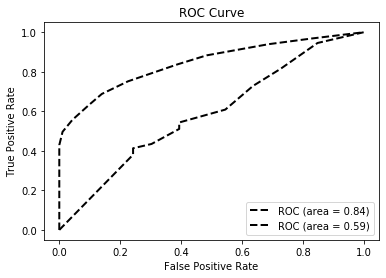

In [82]:
train_x, test_x, train_y, test_y = train_test_split(df2.drop('label',axis=1),df2.label,random_state=1)

lgb = lightgbm.LGBMClassifier()
lgb.fit(train_x, train_y,
        eval_set=[(test_x,test_y)],
        eval_metric='auc',
        early_stopping_rounds=5,
        verbose=-1)


print('train ',model_metrics2(lgb,train_x, train_y))
print('test ',model_metrics2(lgb,test_x,test_y))

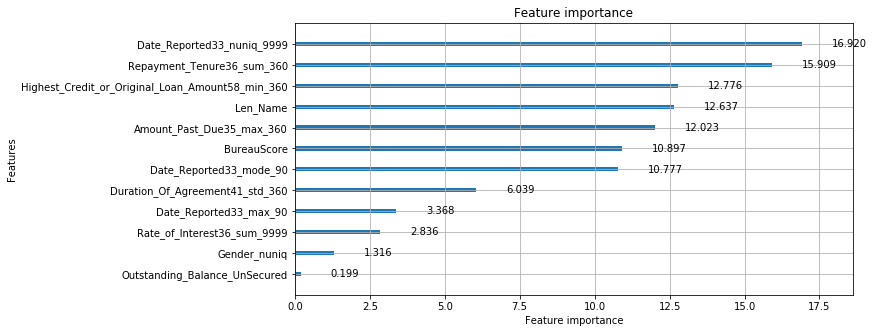

In [83]:
from lightgbm import plot_importance
plot_importance(lgb, max_num_features=20,figsize=(10,5),importance_type='gain')